In [1]:
import sys, os, glob, datetime, cftime,pickle
import xarray as xr
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource
import regionmask
import dask

sys.path.append('../')
from linear_regression import get_slope_and_pval
from _print_and_plot import *

%load_ext autoreload 
%autoreload 2

In [2]:
target_variable='TREFHT'
months=[6,7,8]
months_str = ','.join([str(m) for m in months])
tag = f"{target_variable}_{'m'.join([str(m) for m in months])}"
runs = [1300,1400,1500]
periods = ['1979-2023']

In [3]:
maxabs = 0.4
levels = np.linspace(-maxabs,maxabs,17)
extent = [-180, 180, 30, 60]

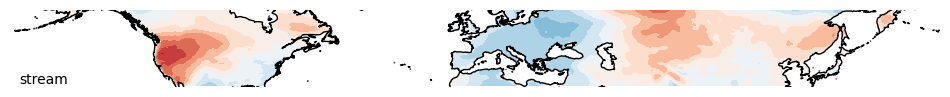

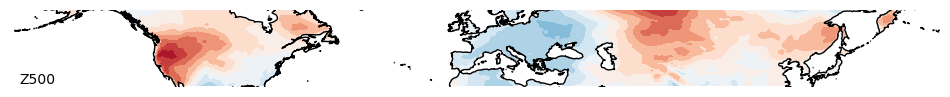

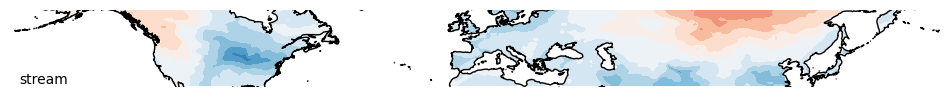

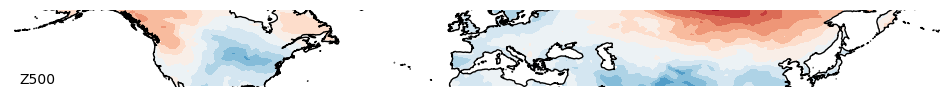

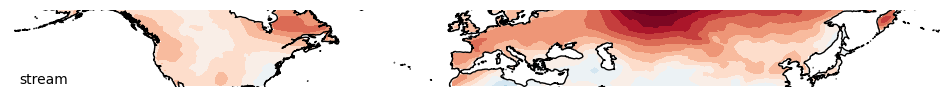

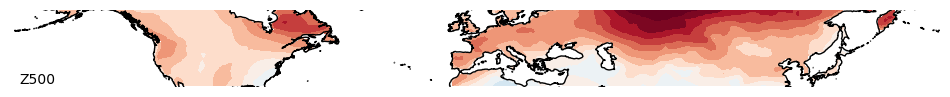

In [7]:

train_test_dict = {1300:1400,1400:1500,1500:1300}
out_path = '/climca/people/ppfleiderer/decomposition/ridge_out'
for period in periods:
    y1,y2 = period.split('-')
    for run_train,run_test in train_test_dict.items():
        for cov_variable in ['stream','Z500']:
            tab = pd.read_csv(f'{out_path}/{tag}_{cov_variable}_vX_alpha1_{run_train}_{period}/train{run_train}_test{run_test}_predict_circ.csv', index_col=0).sort_index().drop_duplicates()
            lat = np.unique(tab.lat.values)
            lon = np.unique(tab.lon.values)
            tas = xr.DataArray(
                    tab.iloc[:,3:].values.reshape((len(lat),len(lon),-1)),
                    dims=['lat','lon','time'],
                    coords=dict(
                        lat=lat, 
                        lon=lon, 
                        time=[datetime.datetime(int(t.split('/')[2]),int(t.split('/')[0]),int(t.split('/')[1])) for t in tab.columns[3:]]
                        )
                )
            tas = tas.transpose('time','lat','lon')

            tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
            tas = tas.assign_coords(year=tas.time.dt.year)
            tas = tas.assign_coords(lat=tas.lat.round(3))
            tas = tas.swap_dims({'time': 'year'})
            tas = tas.loc[y1:y2].roll(lon=144, roll_coords=True)
            tas = tas[np.isin(tas.time.dt.month,months)].loc[:,30:70]
            tas = tas.groupby('year').mean().load()
            slope, pval = get_slope_and_pval(tas)

            mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(slope.lon, slope.lat)
            mask.values[np.isfinite(mask)] = 1
            slope = slope * mask
            pval = pval * mask
            fig,ax = plt.subplots(nrows=1, figsize=(12, 2), subplot_kw={'projection': cartopy.crs.PlateCarree()})
            ax.coastlines()
            ax.set_extent(extent)
            xxx = slope
            im = ax.contourf(xxx.lon, xxx.lat, xxx * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')

            ax.annotate(f"{cov_variable}", xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)
            ax.spines['geo'].set_visible(False)

            savefig(f"trend_maps_{period}_{run_test}_ridge_{cov_variable}")

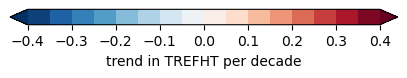

In [6]:
fig,ax = plt.subplots(figsize=(5, 0.2))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'trend in {target_variable} per decade')
savefig(f"trend_maps_cbar_{maxabs}_full")